In [51]:
try:
    import scipy.io as sio
except ImportError:
   
    import scipy.io as sio

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline


In [52]:
# โหลดไฟล์ .mat
file_path = 'IMG_0191.mat'   
varname = 'pl'             

mat = sio.loadmat(file_path)
if varname not in mat:
    raise KeyError(f"ตัวแปร '{varname}' ไม่มีในไฟล์ {file_path}")

vol = mat[varname]
print('volume shape =', vol.shape)

if vol.ndim != 3:
    raise ValueError(f'คาดว่าเป็น 3D volume (ny, nx, nz) แต่ได้ shape = {vol.shape}')

ny, nx, nz = vol.shape
print(f'ny = {ny}, nx = {nx}, nz = {nz} (จำนวนสไลด์)')

volume shape = (201, 201, 61)
ny = 201, nx = 201, nz = 61 (จำนวนสไลด์)


In [53]:

fft_vol = np.fft.fft2(vol, axes=(0, 1))       
fft_vol = np.fft.fftshift(fft_vol, axes=(0, 1))  

print('fft_vol shape =', fft_vol.shape)

fft_vol shape = (201, 201, 61)


In [54]:
# เพิ่มพารามิเตอร์ cmap_img (สีภาพซ้าย) และ cmap_fft (สีภาพขวา)
def show_slice_fft(k, vmin=None, vmax=None, cmap_img='gist_heat', cmap_fft='turbo'):
    
    if not (0 <= k < nz):
        raise ValueError(f'k ต้องอยู่ระหว่าง 0 ถึง {nz-1}')

    img = vol[:, :, k]
    F = fft_vol[:, :, k]
    log_mag = np.log1p(np.abs(F))

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # --- ส่วนปรับความสว่าง (ใช้ code ล่าสุดของคุณ) ---
    if vmin is None: vmin = np.percentile(img, 2)
    if vmax is None: vmax = np.percentile(img, 95) 

    # 1. ภาพซ้าย: ใช้ตัวแปร cmap_img
    im0 = axes[0].imshow(img, cmap=cmap_img, origin='lower', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Original (k={k}) ')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # 2. ภาพขวา: ใช้ตัวแปร cmap_fft
    im1 = axes[1].imshow(log_mag, cmap=cmap_fft, origin='lower')
    axes[1].set_title(f'FFT (k={k}) ')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

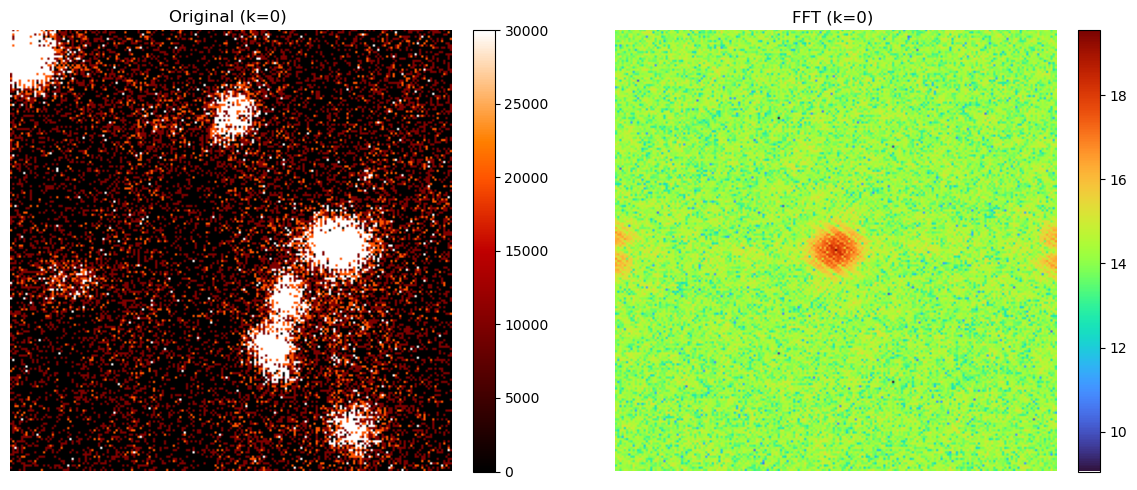

In [55]:
k = 0 
show_slice_fft(k)

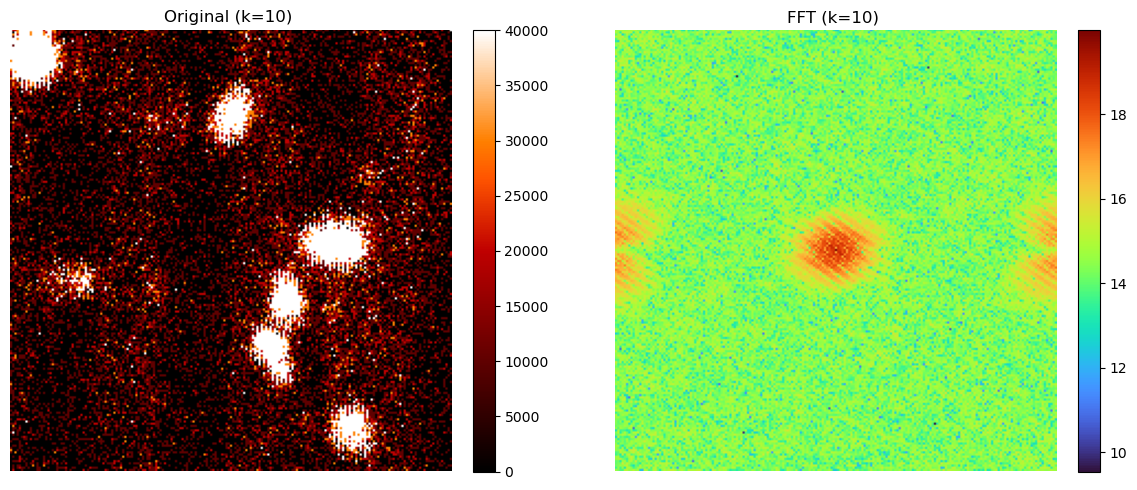

In [56]:
k = 10 
show_slice_fft(k)

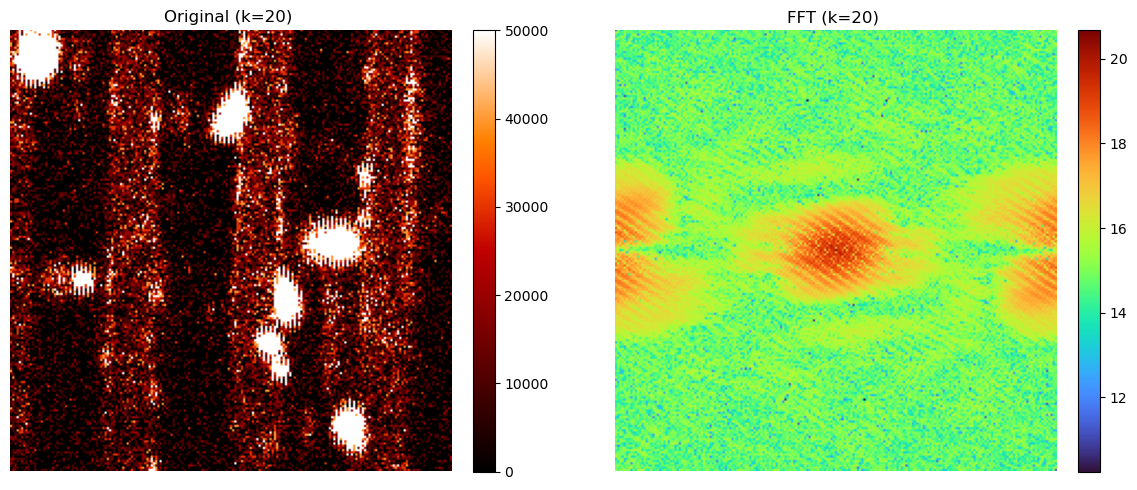

In [57]:
k = 20 
show_slice_fft(k)

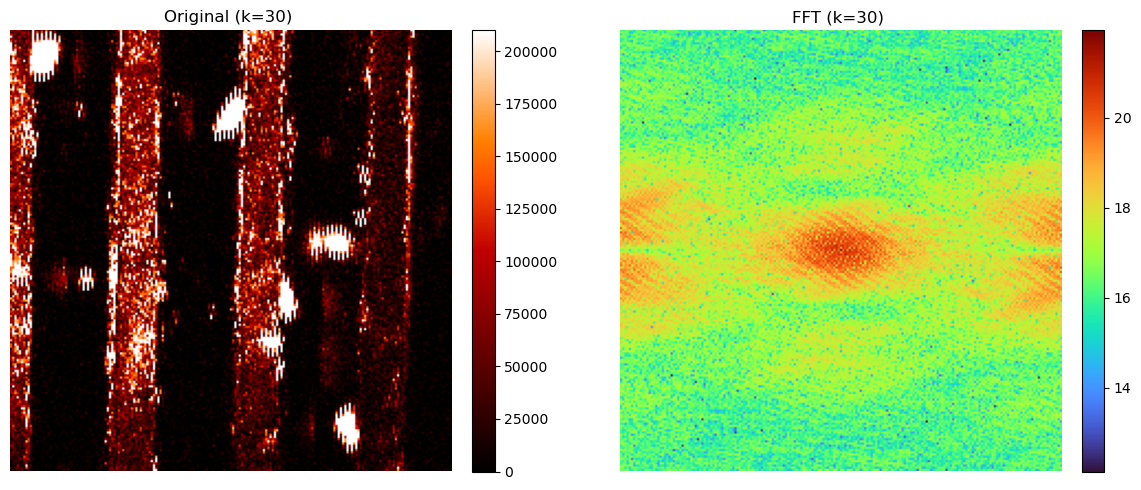

In [58]:
k = 30 
show_slice_fft(k)

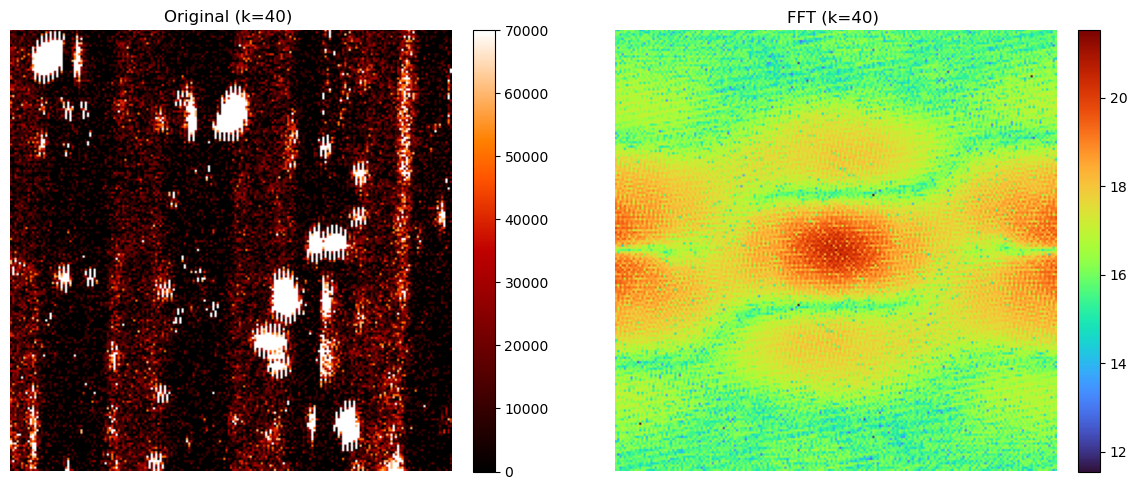

In [59]:
k = 40 
show_slice_fft(k)

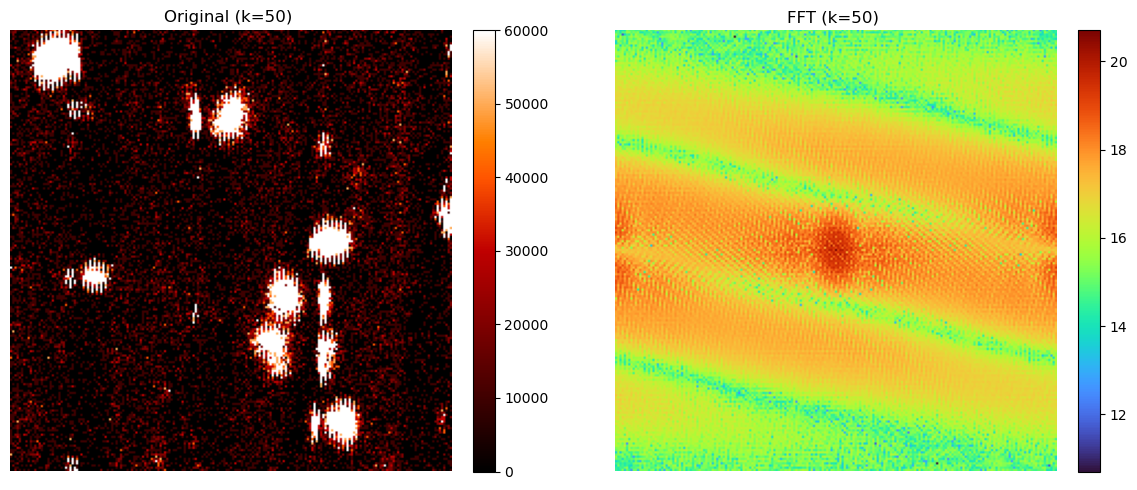

In [60]:
k = 50 
show_slice_fft(k)

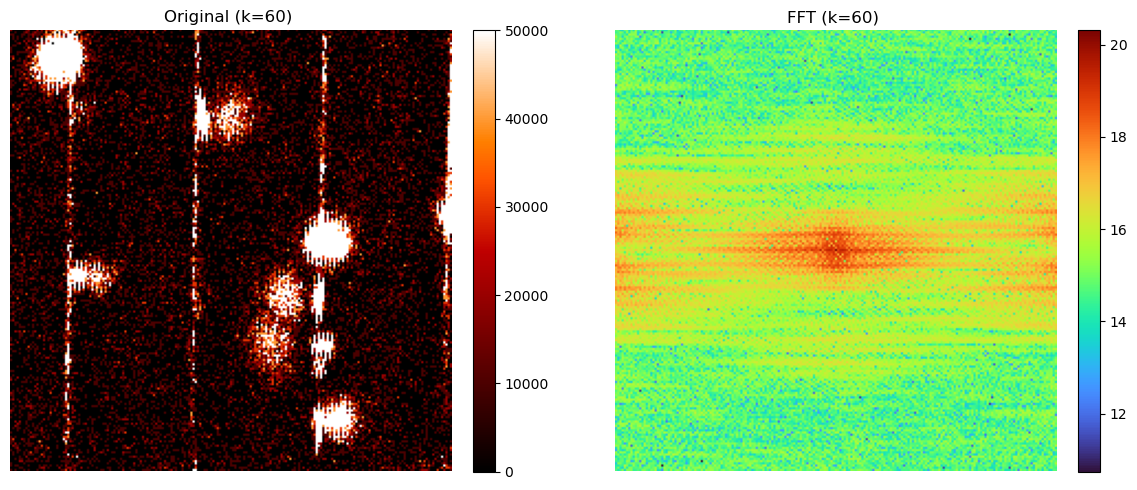

In [61]:
k = 60 
show_slice_fft(k)

Gaussian Lowpass Filter (แบบระฆังคว่ำ)

In [ ]:
# 1. สร้างฟังก์ชันสำหรับทำหน้ากาก Gaussian Lowpass Filter
def create_gaussian_mask(shape, D0):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    
    # สร้าง Grid เพื่อคำนวณระยะห่างจากจุดศูนย์กลาง
    u = np.arange(rows)
    v = np.arange(cols)
    U, V = np.meshgrid(v, u)
    D = np.sqrt((U - ccol)**2 + (V - crow)**2)
    
    # สูตร Gaussian: H(u,v) = e^(-D^2 / 2*D0^2)
    # ค่าจะค่อยๆ ลดจาก 1 ตรงกลาง ไปหา 0 ที่ขอบ แบบระฆังคว่ำ
    mask = np.exp(-(D**2) / (2 * (D0**2)))
    
    return mask

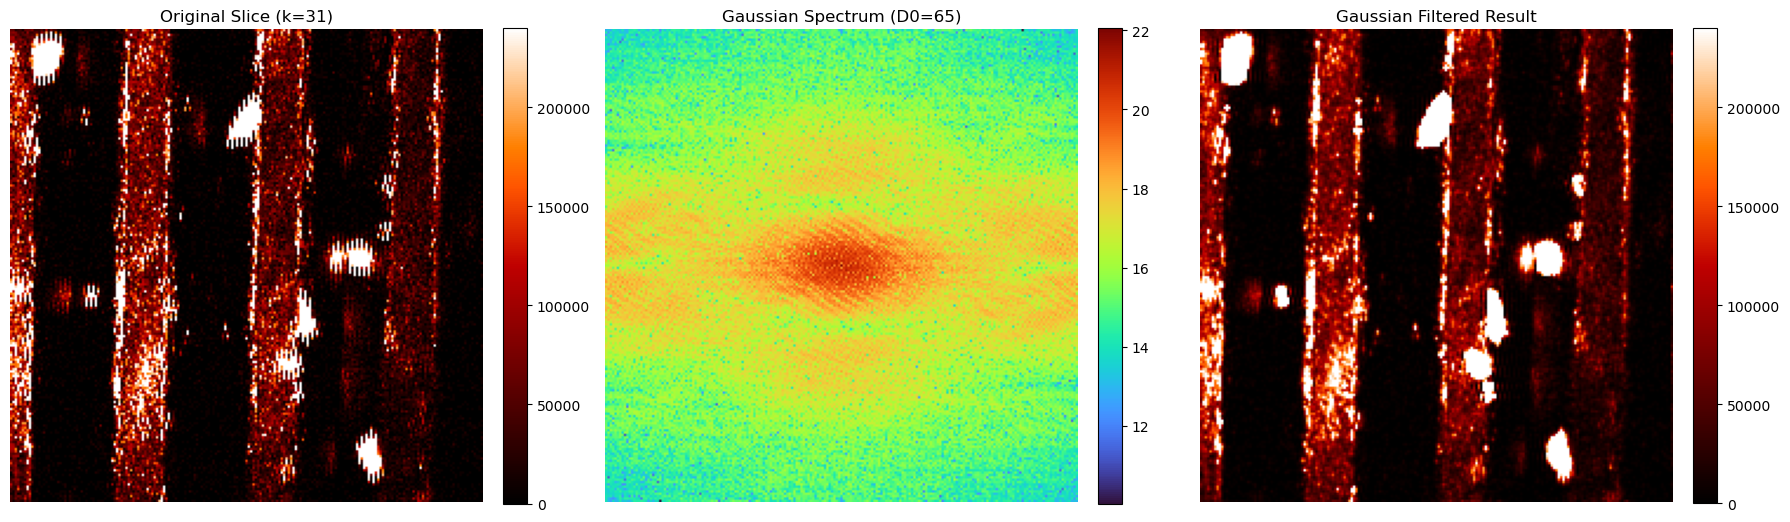

In [ ]:
# 2. ฟังก์ชันสำหรับประมวลผลและแสดงภาพ
def show_gaussian_filter(k, D0=30):
    if not (0 <= k < nz):
        raise ValueError(f'k ต้องอยู่ระหว่าง 0 ถึง {nz-1}')

    # ดึงข้อมูล FFT ของสไลด์นั้นมา (จากตัวแปร global fft_vol)
    F = fft_vol[:, :, k]
    
    # สร้าง Gaussian Mask
    mask = create_gaussian_mask(F.shape, D0)
    
    # คูณ FFT กับ Mask (การกรองในโดเมนความถี่)
    F_filtered = F * mask
    
    # แปลงกลับเป็นภาพด้วย Inverse FFT
    img_back = np.fft.ifft2(np.fft.ifftshift(F_filtered)).real
    
    # ดึงภาพต้นฉบับมาเทียบ
    img_orig = vol[:, :, k]

    # --- ส่วนแสดงผล ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # คำนวณ vmin/vmax แบบ Percentile เพื่อให้ภาพสว่างชัดเจน (ตามที่คุณชอบ)
    vmin = np.percentile(img_orig, 2)
    vmax = np.percentile(img_orig, 95) 

    # ภาพที่ 1: ต้นฉบับ
    im0 = axes[0].imshow(img_orig, cmap='gist_heat', origin='lower', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Original Slice (k={k})')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # ภาพที่ 2: หน้ากาก Gaussian (Spectrum)
    # แสดง log magnitude เพื่อให้เห็นการกระจายตัวของพลังงาน
    log_mag_filt = np.log1p(np.abs(F_filtered))
    im1 = axes[1].imshow(log_mag_filt, cmap='turbo', origin='lower')
    axes[1].set_title(f'Gaussian Spectrum (D0={D0})')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # ภาพที่ 3: ผลลัพธ์หลังกรอง (Filtered Image)
    im2 = axes[2].imshow(img_back, cmap='gist_heat', origin='lower', vmin=vmin, vmax=vmax)
    axes[2].set_title(f'Gaussian Filtered Result')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# ลองปรับค่า D0 ดูครับ: 
# D0 น้อย (เช่น 10) -> ภาพเบลอมาก, Noise หายหมด
# D0 มาก (เช่น 60) -> ภาพคมชัดขึ้น, แต่ Noise อาจจะกลับมา
show_gaussian_filter(k=31, D0=65)

Ideal Lowpass Filter (แบบวงกลมแข็ง)

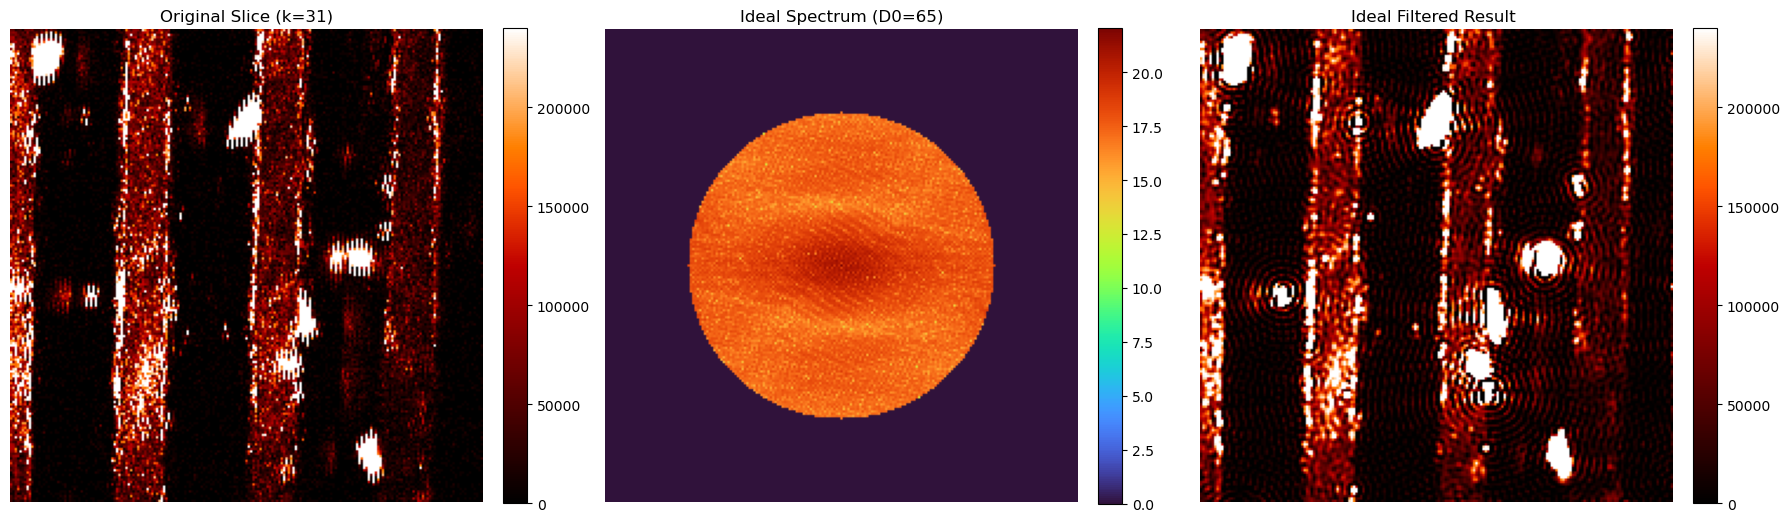

In [64]:
# 1. สร้างฟังก์ชันทำหน้ากาก Ideal (วงกลมขาว-ดำ)
def create_ideal_mask(shape, D0):
    """
    สร้าง Ideal Lowpass Filter (วงกลม)
    shape: ขนาดภาพ (rows, cols)
    D0: รัศมีวงกลม (Cutoff Frequency)
    """
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    
    # สร้าง Grid ระยะห่าง
    u = np.arange(rows)
    v = np.arange(cols)
    U, V = np.meshgrid(v, u)
    D = np.sqrt((U - ccol)**2 + (V - crow)**2)
    
    # สูตร Ideal: ถ้า D <= D0 ให้เป็น 1, ถ้าเกินให้เป็น 0
    mask = np.where(D <= D0, 1, 0)
    
    return mask

# 2. ฟังก์ชันแสดงผล Ideal Filter
def show_ideal_filter(k, D0=30):
    if not (0 <= k < nz):
        raise ValueError(f'k ต้องอยู่ระหว่าง 0 ถึง {nz-1}')

    F = fft_vol[:, :, k]
    
    # สร้าง Ideal Mask
    mask = create_ideal_mask(F.shape, D0)
    
    # คูณ FFT กับ Mask
    F_filtered = F * mask
    
    # แปลงกลับเป็นภาพ
    img_back = np.fft.ifft2(np.fft.ifftshift(F_filtered)).real
    img_orig = vol[:, :, k]

    # --- ส่วนแสดงผล ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    vmin = np.percentile(img_orig, 2)
    vmax = np.percentile(img_orig, 95)

    # 1. Original
    im0 = axes[0].imshow(img_orig, cmap='gist_heat', origin='lower', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Original Slice (k={k})')
    axes[0].axis('off')
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # 2. Spectrum (จะเห็นเป็นวงกลมชัดเจน)
    log_mag_filt = np.log1p(np.abs(F_filtered))
    # ใช้ vmin=0 เพื่อให้เห็นขอบดำตัดชัดๆ
    im1 = axes[1].imshow(log_mag_filt, cmap='turbo', origin='lower') 
    axes[1].set_title(f'Ideal Spectrum (D0={D0})')
    axes[1].axis('off')
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    # 3. Result (สังเกตเงาคลื่นรอบวัตถุ!)
    im2 = axes[2].imshow(img_back, cmap='gist_heat', origin='lower', vmin=vmin, vmax=vmax)
    axes[2].set_title(f'Ideal Filtered Result ')
    axes[2].axis('off')
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


show_ideal_filter(k=31, D0=65)